## SONNMF on Urban Hyperspectral Data

In [1]:
import os
import sys

sys.path.append(os.path.abspath(".."))

In [2]:
import numpy as np
from sklearn.decomposition import NMF
from sonnmf.core.main import sonnmf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import h5py  # For HDF5 file handling

In [3]:
def save_h5(filepath, **kwargs):
    """
    Save data to an HDF5 file.

    Parameters:
        filepath (str): Path to save the file.
        kwargs: Data to save.
    """
    with h5py.File(filepath, 'w') as h5file:
        for key, value in kwargs.items():
            h5file.create_dataset(key, data=value)

def load_h5(filepath):
    """
    Load data from an HDF5 file.

    Parameters:
        filepath (str): Path to the file.

    Returns:
        dict: Loaded data.
    """
    data = {}
    with h5py.File(filepath, 'r') as h5file:
        for key in h5file.keys():
            data[key] = h5file[key][:]
    return data

def initialize_matrices(filepath, m, n, rank):
    """
    Initialize W and H, either by loading from a file or generating randomly.

    Parameters:
        filepath (str): Path to the file to load/save the factors.
        m (int): Number of rows in the data matrix.
        n (int): Number of columns in the data matrix.
        rank (int): Rank for the factorization.

    Returns:
        tuple: Initialized W and H factors.
    """
    if os.path.exists(filepath):
        data = load_h5(filepath)
        W_init = data['W_init']
        H_init = data['H_init']
        print("Loaded initial matrices from file.")
    else:
        W_init = np.random.rand(m, rank)
        H_init = np.random.rand(rank, n)
        save_h5(filepath, W_init=W_init, H_init=H_init)
    return W_init, H_init

In [4]:
def plot_separate_H(H, img_size, figsize, fontsize, num_rows=4, normalize_row=False, filename=None):
    """
    Plot separate H matrices (abundance maps) as individual subplots.
    
    Parameters:
        H (np.ndarray): H matrix (abundance maps).
        img_size (tuple): Image dimensions (height, width).
        figsize (tuple): Figure size.
        fontsize (int): Font size for titles.
        num_rows (int): Number of rows in subplot grid.
        normalize_row (bool): Whether to normalize rows.
        filename (str, optional): Filename to save the plot.
    """
    rank = H.shape[0]
    if normalize_row:
        H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-12)
    
    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')
    num_cols = int(np.ceil(rank / num_rows))
    
    if num_rows > 1:
        fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
        axs = axs.ravel() if num_rows * num_cols > 1 else [axs]
        
        for cnt in range(num_rows * num_cols):
            if cnt < rank:
                img = axs[cnt].imshow(H3d[cnt, :, :], cmap='gray')
                axs[cnt].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
                axs[cnt].axis('off')
                divider = make_axes_locatable(axs[cnt])
                cax = divider.append_axes('right', size='5%', pad=0.1)
                fig.colorbar(img, cax=cax, orientation='vertical')
            else:
                axs[cnt].axis('off')
    else:
        fig, axs = plt.subplots(1, rank, figsize=figsize)
        if rank == 1:
            axs = [axs]
        
        for cnt in range(rank):
            img = axs[cnt].imshow(H3d[cnt, :, :], cmap='gray')
            axs[cnt].set_title(f'$h^{{{cnt + 1}}}$', fontsize=fontsize)
            axs[cnt].axis('off')
            divider = make_axes_locatable(axs[cnt])
            cax = divider.append_axes('right', size='5%', pad=0.1)
            fig.colorbar(img, cax=cax, orientation='vertical')
    
    plt.tight_layout()
    if filename:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()

def plot_combined_H(H, img_size, figsize, num_rows=1, normalize_row=False, filename=None):
    """
    Plot combined H matrices (abundance maps) as a single concatenated image.
    
    Parameters:
        H (np.ndarray): H matrix (abundance maps).
        img_size (tuple): Image dimensions (height, width).
        figsize (tuple): Figure size.
        num_rows (int): Number of rows for arrangement.
        normalize_row (bool): Whether to normalize rows.
        filename (str, optional): Filename to save the plot.
    """
    if normalize_row:
        H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-12)

    H3d = H.reshape(-1, img_size[0], img_size[1], order='F')

    if num_rows > 1:
        num_cols = int(np.ceil(H.shape[0] / num_rows))
        large_mat = np.vstack([np.hstack(H3d[i * num_cols: (i+1) * num_cols]) for i in range(num_rows)])
    else:
        large_mat = np.hstack(H3d)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(large_mat, cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='3%', pad=0.1)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()

    if filename:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()

def plot_spectral_signatures(W, figsize, fontsize, n_rows=1, filename=None, scale_y=False, plot_title=None):
    """
    Plot spectral signatures (W matrix columns).
    
    Parameters:
        W (np.ndarray): W matrix (spectral signatures).
        figsize (tuple): Figure size.
        fontsize (int): Font size for titles.
        n_rows (int): Number of rows in subplot grid.
        filename (str, optional): Filename to save the plot.
        scale_y (bool): Whether to scale y-axis uniformly.
        plot_title (str, optional): Title for the entire figure.
    """
    rank = W.shape[1]
    wmin, wmax = np.min(W), np.max(W)

    n_cols = int(np.ceil(rank / n_rows))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
    axs = axs.ravel() if n_rows * n_cols > 1 else [axs]

    for cnt in range(len(axs)):
        if cnt < rank:
            axs[cnt].plot(W[:, cnt], linewidth=3)
            if scale_y:
                axs[cnt].set_ylim([min(0, wmin), wmax])

            axs[cnt].set_title(f'$w_{{{cnt + 1}}}$', fontsize=fontsize)
            axs[cnt].set_xlabel('Bands')
            axs[cnt].set_ylabel('Reflectance')
        else:
            axs[cnt].axis('off')

    plt.tight_layout()
    if plot_title:
        fig.suptitle(plot_title, fontsize=25, y=1.02)
    if filename:
        fig.savefig(filename, bbox_inches='tight')
        plt.close()

def merge_images(images_list, filename, delete_images=False):
    """
    Merge multiple images vertically into a single image.
    
    Parameters:
        images_list (list): List of image file paths.
        filename (str): Output filename for merged image.
        delete_images (bool): Whether to delete original images after merging.
    """
    imgs = [Image.open(i) for i in images_list]
    
    # Convert all images to RGB mode to ensure consistency
    imgs = [img.convert('RGB') for img in imgs]
    
    min_img_width = min(i.width for i in imgs)

    total_height = 0
    for i, img in enumerate(imgs):
        if img.width > min_img_width:
            imgs[i] = img.resize((min_img_width, int(img.height / img.width * min_img_width)), Image.Resampling.LANCZOS)
        total_height += imgs[i].height

    # Create merged image with white background in RGB mode
    img_merge = Image.new('RGB', (min_img_width, total_height), color='white')
    y = 0
    for img in imgs:
        img_merge.paste(img, (0, y))
        y += img.height

    img_merge.save(filename)

    if delete_images:
        for fp in images_list:
            os.remove(fp)

def plot_and_merge(W, H, imgsize, figsize, fontsize, filenames, num_rows, delete=False, show_final=False):
    """
    Create comprehensive plots and merge them into a single image.
    
    Parameters:
        W (np.ndarray): Spectral signatures matrix.
        H (np.ndarray): Abundance maps matrix.
        imgsize (tuple): Image dimensions.
        figsize (tuple): Figure size.
        fontsize (int): Font size.
        filenames (list): List of filenames for individual plots and final merged image.
        num_rows (int): Number of rows for subplot arrangement.
        delete (bool): Whether to delete individual images after merging.
        show_final (bool): Whether to display the final merged image.
    """
    plot_spectral_signatures(W, figsize, fontsize=fontsize, n_rows=num_rows, filename=filenames[0])
    plot_separate_H(H, imgsize, figsize=figsize, fontsize=fontsize, num_rows=num_rows, filename=filenames[1])
    plot_combined_H(H, imgsize, figsize=figsize, num_rows=num_rows, filename=filenames[2])
    
    if show_final:
        temp_png = filenames[3].replace('.pdf', '_temp_display.png')
        merge_images(filenames[:3], temp_png, delete_images=False)
        
        # Display the temporary merged image
        final_img = Image.open(temp_png)
        plt.figure(figsize=(12, 8))
        plt.imshow(final_img)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Now create the final PDF version
        merge_images(filenames[:3], filenames[3], delete_images=delete)
        
        # Clean up temporary PNG file
        os.remove(temp_png)
    else:
        # Just create the final file directly
        merge_images(filenames[:3], filenames[3], delete_images=delete)


In [5]:
saved_model_dir = '../saved_models/urban_full/'
os.makedirs(saved_model_dir, exist_ok=True)

images_dir = '../images/'
os.makedirs(images_dir, exist_ok=True)

### Loading Urban Hyperspectral Data


In [ ]:
data_filepath = '../datasets/urban_full.h5' # TODO: change X to M
if os.path.exists(data_filepath):
    data = load_h5(data_filepath)
    M = data['X'].astype(np.float64)
else:
    raise FileNotFoundError(f"Urban dataset not found at {data_filepath}")

m, n = M.shape
img_height, img_width = 307, 307  # Urban dataset dimensions
print(f"Data matrix shape: {M.shape}")
print(f"Image dimensions: {img_height} x {img_width}")
print(f"Number of spectral bands: {m}")
print(f"Number of pixels: {n}")

Data matrix shape: (162, 94249)
Image dimensions: 307 x 307
Number of spectral bands: 162
Number of pixels: 94249


### Experiment: SONNMF vs Vanilla NMF for Urban Hyperspectral Unmixing

In [7]:
# Experiment parameters
rank = 20
max_iters = 1000
lambda_reg = 1000000  # Regularization parameter for sparsity
gamma_reg = 1000000   # Regularization parameter for total variation

In [8]:
# Initialize W and H matrices
ini_filepath = os.path.join(saved_model_dir, f'rank{rank}_init.h5')
W_init, H_init = initialize_matrices(ini_filepath, m, n, rank)

Loaded initial matrices from file.


In [9]:
# SONNMF
sonnmf_filepath = os.path.join(saved_model_dir, f'sonnmf_rank{rank}_lambda{lambda_reg}_gamma{gamma_reg}_iters{max_iters}.h5')
if os.path.exists(sonnmf_filepath):
    data = load_h5(sonnmf_filepath)
    W_sonnmf = data['W']
    H_sonnmf = data['H']
    print("Loaded SONNMF results from file.")
else:
    print("Running SONNMF...")
    W_sonnmf, H_sonnmf, fscores, gscores, hscores, total_scores = sonnmf(
        M, W_init.copy(), H_init.copy(), 
        lam=lambda_reg, gamma=gamma_reg, 
        itermax=max_iters, W_update_iters=10, 
        early_stop=True, verbose=False
    )
    save_h5(sonnmf_filepath, W=W_sonnmf, H=H_sonnmf, fscores=fscores, 
            gscores=gscores, hscores=hscores, total_scores=total_scores)
    print("SONNMF completed and results saved.")

Loaded SONNMF results from file.


In [10]:
# Vanilla NMF
vanilla_filepath = os.path.join(saved_model_dir, f'vanilla_rank{rank}_iters{max_iters}.h5')
if os.path.exists(vanilla_filepath):
    data = load_h5(vanilla_filepath)
    W_vanilla = data['W']
    H_vanilla = data['H']
    print("Loaded vanilla NMF results from file.")
else:
    print("Running vanilla NMF...")
    model = NMF(n_components=rank, init='custom', random_state=42, max_iter=max_iters)
    W_vanilla = model.fit_transform(X=M, W=W_init.copy(), H=H_init.copy())
    H_vanilla = model.components_
    save_h5(vanilla_filepath, W=W_vanilla, H=H_vanilla)
    print("Vanilla NMF completed and results saved.")

Loaded vanilla NMF results from file.


### Results Analysis and Visualization

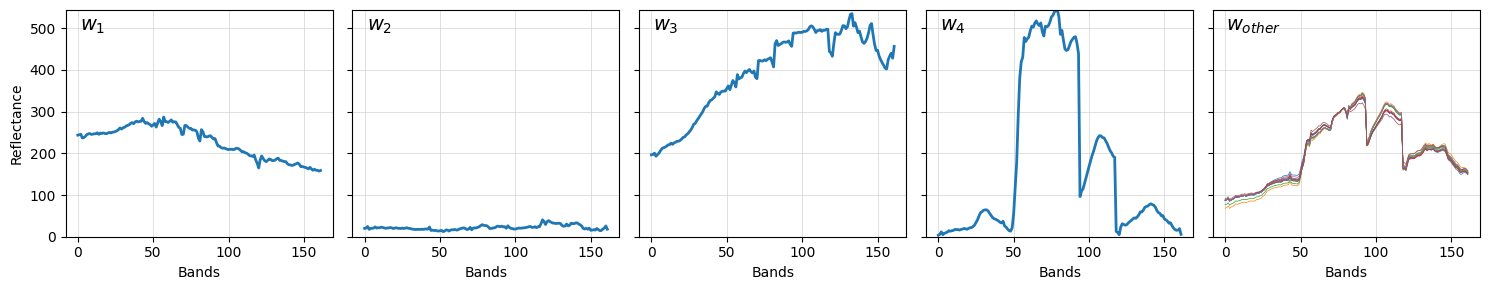

In [11]:
unique_idxs = [5, 7, 13, 15]  # Indices of distinct spectral signatures
other_idxs = [x for x in range(rank) if x not in unique_idxs]

# Plot SONNMF spectral signatures
wmin, wmax = np.min(W_sonnmf), np.max(W_sonnmf)

fig, axs = plt.subplots(1, len(unique_idxs) + 1, figsize=(15, 3), sharex=True, sharey=True)
axs = axs.ravel()

for cnt, ax in enumerate(axs):
    if cnt == 0:
        ax.set_ylabel('Reflectance')
    ax.set_xlabel('Bands')
    ax.set_ylim([min(0, wmin), wmax])
    ax.grid(which='both', linewidth=0.5, color='lightgrey')

# Plot unique spectral signatures
for ax_idx, w_idx in enumerate(unique_idxs):
    axs[ax_idx].plot(W_sonnmf[:, w_idx], linewidth=2)
    axs[ax_idx].set_title(f'$w_{{{ax_idx + 1}}}$', fontsize=14, x=0.1, y=0.87)

# Plot other signatures overlapped
axs[-1].plot(W_sonnmf[:, other_idxs], linewidth=0.5)
axs[-1].set_title('$w_{{other}}$', fontsize=14, x=0.15, y=0.87)

# plt.suptitle('SONNMF Spectral Signatures', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'urban_sonnmf_spectral_signatures.pdf'), bbox_inches='tight')
plt.show()

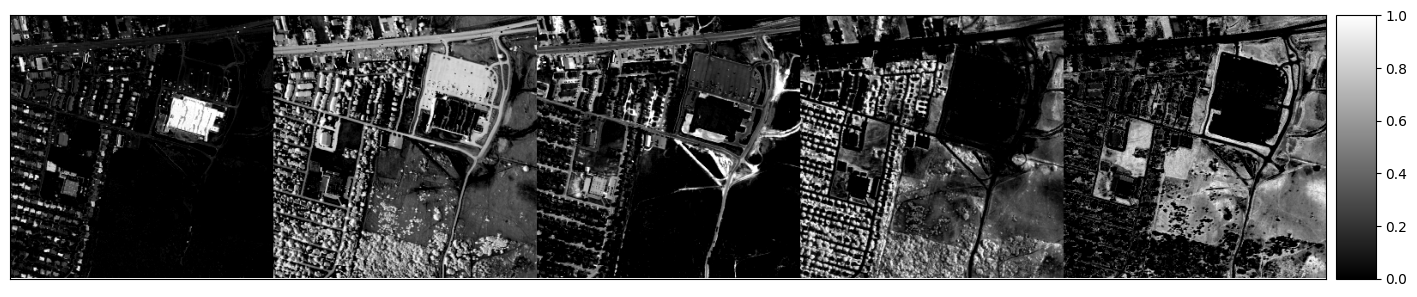

In [12]:
# Abundance map visualization for key endmembers
newH = np.vstack((H_sonnmf[unique_idxs, :], H_sonnmf[other_idxs, :].sum(axis=0, keepdims=True)))
newH3d = newH.reshape(-1, img_height, img_width, order='F')
large_mat = np.hstack(newH3d)

fig, ax = plt.subplots(figsize=(15, 3))
img = ax.imshow(large_mat, cmap='gray')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.1)
fig.colorbar(img, cax=cax, orientation='vertical')
ax.set_xticks([])
ax.set_yticks([])
# ax.set_title('SONNMF Abundance Maps (Key Endmembers + Others Combined)', fontsize=14)

plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'urban_sonnmf_abundance_maps.pdf'), bbox_inches='tight')
plt.show()

In [13]:
# Vanilla NMF results
filenames = [
    os.path.join(images_dir, 'tmp_vanilla_w.png'),
    os.path.join(images_dir, 'tmp_vanilla_seph.png'), 
    os.path.join(images_dir, 'tmp_vanilla_combh.png'),
    os.path.join(images_dir, 'urban_vanilla_comprehensive.pdf')
]

plot_and_merge(W_vanilla, H_vanilla, (img_height, img_width), (33, 6), 16, filenames, 2, delete=True, show_final=False)
print("Comprehensive vanilla NMF visualization saved.")

Comprehensive vanilla NMF visualization saved.


In [14]:
# SONNMF results
filenames = [
    os.path.join(images_dir, 'tmp_sonnmf_w.png'),
    os.path.join(images_dir, 'tmp_sonnmf_seph.png'), 
    os.path.join(images_dir, 'tmp_sonnmf_combh.png'),
    os.path.join(images_dir, 'urban_sonnmf_comprehensive.pdf')
]

plot_and_merge(W_sonnmf, H_sonnmf, (img_height, img_width), (33, 6), 16, filenames, 2, delete=True, show_final=False)
print("Comprehensive SONNMF visualization saved.")

Comprehensive SONNMF visualization saved.
